<a href="https://colab.research.google.com/github/amal-babu-git/TransferLearning-colab-notes/blob/main/04_TL_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning 01:Feature extraction

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()


--2022-02-10 08:14:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  46.7MB/s    in 3.4s    

2022-02-10 08:14:44 (46.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [ ]:
# preprocess the data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATH_SIZE=32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("Training images")
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATH_SIZE,
                                                        class_mode="categorical")
print("Testing data")
test_data=test_datagen.flow_from_directory(test_dir,
                                           target_size=IMAGE_SHAPE,
                                           batch_size=BATH_SIZE,
                                           class_mode="categorical")

Training images
Found 750 images belonging to 10 classes.
Testing data
Found 2500 images belonging to 10 classes.


In [ ]:
import datetime
def create_tensorbord_callback(dir_name,experiment_name):
  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorbord_callback=tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving tensorbord log file to : {log_dir}")
  return tensorbord_callback


In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
efficientnet_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [ ]:
def create_model(model_url,num_classes=10):
  """
  This function takes a TensorFlow Hub URL and create a keras sequential model
  with it.
  Args:
        model_url(str) : A TensorFlow Hub feature extraction url
        num_classes(int) : Number of output neurons in output layer,
        should be equal to the number of target classes, default 10.
  Returns:
        An uncomiled keras sequential model
  """
  #Download the pre trained model and save it as keras layer
  feature_extractor_layer=hub.KerasLayer(model_url,
                                         trainable=False,#freeze the underlying patterns
                                         input_shape=IMAGE_SHAPE+(3,),
                                         name="feature_extraction_layer")
  #create our own model
  model=tf.keras.Sequential(
      [
       feature_extractor_layer,
       layers.Dense(num_classes,activation="softmax",name="output_layer")
      ]
  )
  
  return model

In [10]:
# create model
resnet_model=create_model(resnet_url,num_classes=10)
# compile the model
resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])
# fit the model
resnet_history=resnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorbord_callback(
                                    dir_name="tensorflow_hub",
                                    experiment_name="resnetV250"
                                )])

Saving tensorbord log file to : tensorflow_hub/resnetV250/20220210-081457
Epoch 1/5
24/24 [==============================] - 421s 18s/step - loss: 1.9198 - accuracy: 0.3640 - val_loss: 1.1904 - val_accuracy: 0.6284
Epoch 2/5
24/24 [==============================] - 416s 18s/step - loss: 0.8915 - accuracy: 0.7400 - val_loss: 0.8424 - val_accuracy: 0.7224
Epoch 3/5
24/24 [==============================] - 397s 17s/step - loss: 0.6116 - accuracy: 0.8320 - val_loss: 0.7656 - val_accuracy: 0.7448
Epoch 4/5
24/24 [==============================] - 414s 18s/step - loss: 0.4776 - accuracy: 0.8800 - val_loss: 0.7088 - val_accuracy: 0.7652
Epoch 5/5
24/24 [==============================] - 413s 18s/step - loss: 0.3732 - accuracy: 0.9160 - val_loss: 0.6877 - val_accuracy: 0.7704


In [11]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Args:
        history: history object
  returns:
          separate loss curves for training and validation metrics
  """
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]

  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]

  epochs=range(len(history.history["loss"]))

  # plot loss
  plt.plot(epochs,loss,label="training loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuraccy")
  plt.xlabel("Epocs")
  plt.legend();

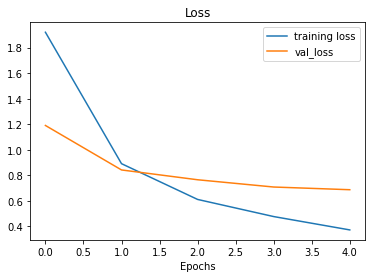

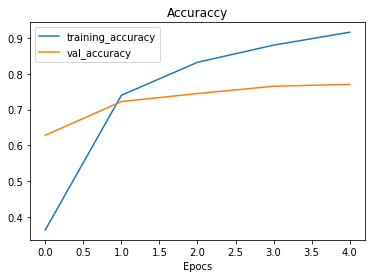

In [12]:
plot_loss_curves(resnet_history)

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# creating efficientnet model
efficientnet_model=create_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)
# compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])
# fit the efficientnet model
efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data,
                       validation_steps=len(test_data),
                       callbacks=[
                                  create_tensorbord_callback(dir_name="tensorflow_hub",
                                                             experiment_name="efficientnetB0")
                       ])

Saving tensorbord log file to : tensorflow_hub/efficientnetB0/20220210-085018
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.7975 - accuracy: 0.4640

In [ ]:
plot_loss_curves(efficientnet_history)